--- EXECUTANDO EM MODO COMPLETO ---
Carregando dados simulados de: ../data/train.hdf5
Carregando dados experimentais de: ../data/experimental_features_unfiltered.hdf5

Validando e limpando dados...
Validação completa.
--- Treinando modelo PPO ---
--- Resumo do Ambiente (Episódio 25) ---
  TPR Final: 41.07%, FPR Final: 23.21%, Recompensa Final: 0.11
--- Resumo do Ambiente (Episódio 50) ---
  TPR Final: 53.57%, FPR Final: 28.57%, Recompensa Final: 0.21
--- Logs da Biblioteca (Episódio 50) ---
  train/learning_rate: 0.0003
  train/entropy_loss: -0.5665
  train/policy_gradient_loss: -0.0336
  train/value_loss: 9.9546
  train/approx_kl: 0.0218
  train/clip_fraction: 0.3293
  train/loss: 4.5992
  train/explained_variance: 0.0458
  train/n_updates: 20.0000
  train/clip_range: 0.2000
---------------------------------------
--- Resumo do Ambiente (Episódio 75) ---
  TPR Final: 76.79%, FPR Final: 14.29%, Recompensa Final: 0.57
--- Resumo do Ambiente (Episódio 100) ---
  TPR Final: 89.29%, FPR Fi

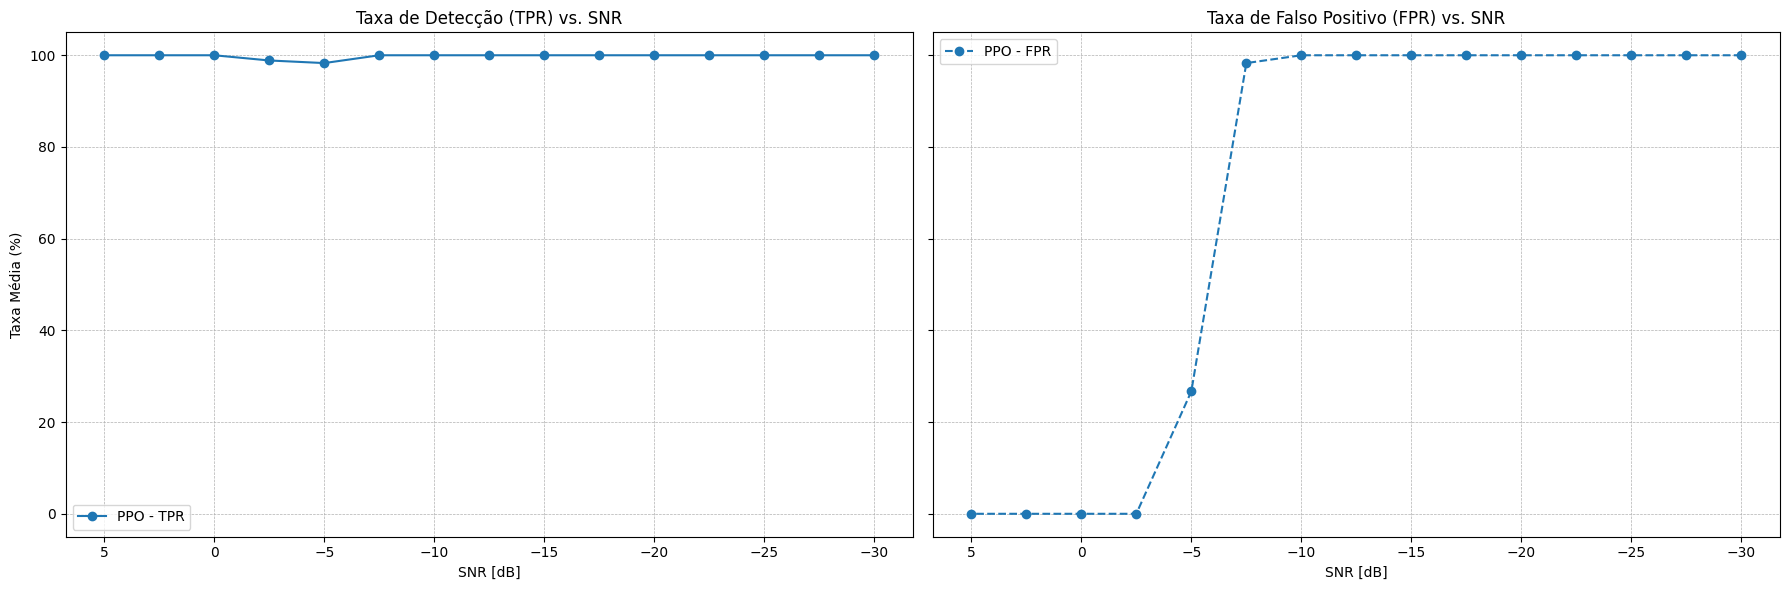


--- Avaliando modelo PPO em dados EXPERIMENTAIS com retreinamento ---
  Intensidade 70 dB -> TPR: 100.00%, FPR: 99.70%
  Intensidade 60 dB -> TPR: 100.00%, FPR: 100.00%
  Intensidade 50 dB -> TPR: 100.00%, FPR: 93.50%
  Intensidade 40 dB -> TPR: 100.00%, FPR: 99.93%
  Intensidade 30 dB -> TPR: 100.00%, FPR: 98.68%
----------------------------------------


In [ ]:
# -*- coding: utf-8 -*-
"""
Notebook Refatorado v15 para Treinamento de Modelo PPO com Engenharia de Features Configurável.

Esta versão foca exclusivamente no modelo PPO e introduz um sistema flexível
para engenharia de features. Os usuários podem definir uma lista de features
e suas transformações (simples, média móvel, soma/média cumulativa) para construir
o espaço de observação do agente de RL.
"""

# %% [markdown]
# # Treinamento de Modelo PPO com Features Configuráveis (v15)
#
# # Este notebook treina e avalia um modelo PPO, permitindo a seleção e transformação customizada de features para compor o estado de observação do agente.

# %% [code]
# Importações essenciais
import pickle
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import BaseCallback
import torch as th
import matplotlib.pyplot as plt
import h5py
import warnings

# Ignorar alguns avisos comuns para manter a saída limpa
warnings.filterwarnings("ignore", category=UserWarning)

# %% [markdown]
# ## Parâmetros de Controle e Configuração de Features

# %% [code]
# #####################################################################
# FEATURE ENGINEERING CONFIGURATION (AJUSTÁVEL PELO USUÁRIO)
# #####################################################################
# Defina as features e transformações a serem usadas pelo agente.
# Formato: ('nome_da_feature', 'tipo_transformacao', {parâmetros})
#
# Nomes de Features Disponíveis: 'MSC', 'CSM', 'TFG', 'TFL', 'SNR_meas', 'MAG_freq', 'PHI_freq'
# Feature Especial: 'timestamp'
#
# Tipos de Transformação:
# - 'simple': Valor atual da feature.
# - 'moving_mean': Média móvel. Requer {'window_size': N}.
# - 'cumsum': Soma cumulativa desde o início do episódio.
# - 'cummean': Média cumulativa desde o início do episódio.
# #####################################################################

FEATURE_NAMES = ['MSC', 'CSM', 'TFG', 'TFL', 'SNR_meas', 'MAG_freq', 'PHI_freq']

# FEATURE_CONFIG = [
#     # --- Features Simples (valor atual) ---
#     ('MSC', 'simple', {}),
#     ('CSM', 'simple', {}),
#     ('TFL', 'simple', {}),
#     ('SNR_meas', 'simple', {}),
#     ('MAG_freq', 'simple', {}),

#     # --- Features de Média Móvel ---
#     ('MSC', 'moving_mean', {'window_size': 18}),
#     ('CSM', 'moving_mean', {'window_size': 18}),
#     ('TFL', 'moving_mean', {'window_size': 18}),
#     ('MAG_freq', 'moving_mean', {'window_size': 18}),

#     # --- Feature de Tempo ---
#     ('timestamp', 'simple', {})
# ]

FEATURE_CONFIG = [
    # --- Features Simples (valor atual) ---
    ('MSC', 'simple', {}),
    ('CSM', 'simple', {}),
    ('TFL', 'simple', {}),
    ('SNR_meas', 'simple', {}),
    ('MAG_freq', 'simple', {}),

    # --- Features de Média Móvel ---
    ('MSC', 'moving_mean', {'window_size': 18}),
    ('CSM', 'moving_mean', {'window_size': 18}),
    ('TFL', 'moving_mean', {'window_size': 18}),
    ('MAG_freq', 'moving_mean', {'window_size': 18}),

    ('MSC', 'cumsum',{}),
    ('CSM', 'cumsum',{}),
    ('TFL', 'cumsum',{}),
    ('MAG_freq', 'cumsum',{}),

    # --- Feature de Tempo ---
    ('timestamp', 'simple', {})
]



# #####################################################################
# MODO DE EXECUÇÃO E PARÂMETROS GLOBAIS
# #####################################################################
DRY_RUN = False # Mude para False para uma execução completa

if DRY_RUN:
    print("--- EXECUTANDO EM MODO DRY RUN (TESTE RÁPIDO) ---")
    TOTAL_TIMESTEPS_TREINO, EVAL_SIM_TIMESTEPS = 2500, 1000
    VERBOSE_LEVEL, VERBOSE_FREQ, SB3_LOG_FREQ = 1, 5, 10
else:
    print("--- EXECUTANDO EM MODO COMPLETO ---")
    TOTAL_TIMESTEPS_TREINO, EVAL_SIM_TIMESTEPS = 15000, 2500
    VERBOSE_LEVEL, VERBOSE_FREQ, SB3_LOG_FREQ = 1, 25, 50

# #####################################################################
# CAMINHOS E CONSTANTES
# #####################################################################
HDF5_SIMULATED_FILEPATH = '../data/train.hdf5'
EXPERIMENTAL_FEATURES_FILE = '../data/experimental_features_unfiltered.hdf5'
NUM_SIGNAL_FREQS = 8

# %% [markdown]
# ## Carga e Preparação dos Dados (HDF5)

# %% [code]
def load_and_adapt_hdf5_data(sim_path, exp_path):
    """Carrega dados HDF5 e os adapta para o formato do notebook original."""
    c_states_simulado = {}
    c_states_experimental = {}

    print(f"Carregando dados simulados de: {sim_path}")
    with h5py.File(sim_path, 'r') as f:
        snr_keys = sorted([key for key in f.keys() if 'snr' in key], key=lambda x: float(x.split('_')[1]))
        for key in snr_keys:
            snr_val = float(key.split('_')[1])
            data = f[key]['metrics'][:]
            # Formato adaptado: (trials, steps, features) - Remove a dimensão extra de 'window'
            c_states_simulado[snr_val] = data

    print(f"Carregando dados experimentais de: {exp_path}")
    intensidades_map = {70:(4,1), 60:(4,2), 50:(4,3), 40:(4,4), 30:(4,5)}
    try:
        with h5py.File(exp_path, 'r') as f:
            first_volunteer = list(f.keys())[0]
            intensity_keys = sorted(f[first_volunteer].keys())
            for i, intensity_key in enumerate(list(intensidades_map.values())):
                if i < len(intensity_keys):
                    h5_intensity_key = intensity_keys[i]
                    data = f[first_volunteer][h5_intensity_key]['metrics'][:]
                    # Transpõe para (steps, features, trials) para simular (freqs, measures, windows)
                    c_states_experimental[intensity_key] = data.transpose(1, 2, 0)
    except (FileNotFoundError, IndexError):
        print(f"Aviso: Arquivo de dados experimentais '{exp_path}' não encontrado. Avaliação experimental será pulada.")

    return c_states_simulado, c_states_experimental

c_states_simulado, c_states_experimental = load_and_adapt_hdf5_data(
    HDF5_SIMULATED_FILEPATH, EXPERIMENTAL_FEATURES_FILE
)

# Validação e Limpeza
def clean_data_dict(data_dict):
    for key, array in data_dict.items():
        if np.isnan(array).any() or np.isinf(array).any():
            print(f"Aviso: Limpando valores inválidos para a chave '{key}'.")
            data_dict[key] = np.nan_to_num(array, nan=0.0, posinf=0.0, neginf=0.0)
    return data_dict

print("\nValidando e limpando dados...")
c_states_simulado = clean_data_dict(c_states_simulado)
c_states_experimental = clean_data_dict(c_states_experimental)
print("Validação completa.")

# %% [code]
# FUNÇÃO DE NORMALIZAÇÃO
def my_norm(val, min_val=0, max_val=3):
    # Evita divisão por zero se max_val == min_val
    if max_val == min_val:
        return val - min_val
    return (val - min_val) / (max_val - min_val)

# %% [markdown]
# ## Ambientes Gymnasium com Engenharia de Features Dinâmica

# %% [code]
class CustomLoggingCallback(BaseCallback):
    def __init__(self, log_freq: int, verbose=0):
        super().__init__(verbose)
        self.log_freq, self.episode_count = log_freq, 0
    def _on_step(self) -> bool:
        if any(self.locals["dones"]):
            self.episode_count += 1
            if self.episode_count % self.log_freq == 0 and self.logger.name_to_value:
                print(f"--- Logs da Biblioteca (Episódio {self.episode_count}) ---")
                for key, value in self.logger.name_to_value.items():
                    print(f"  {key}: {value:.4f}")
                print("---------------------------------------")
        return True

class FeatureEngineEnv(gym.Env):
    """Classe base para ambientes que usam a engenharia de features configurável."""
    def __init__(self, data, feature_config, feature_names):
        super().__init__()
        self.data = data
        self.feature_config = feature_config
        self.feature_names = feature_names
        self.feature_indices = {name: i for i, name in enumerate(feature_names)}

        # Calcula o tamanho do espaço de observação
        num_output_features = 0
        for name, _, _ in self.feature_config:
            if name == 'timestamp':
                num_output_features += 1
            else: # Assume que cada feature base contribui com 1 valor
                num_output_features += 1

        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(num_output_features,), dtype=np.float32
        )

    def _generate_state(self, history_data, current_step, total_steps):
        state_features = []
        for feature, transform, params in self.feature_config:
            if feature == 'timestamp':
                # Normaliza o timestamp
                state_features.append(current_step / total_steps if total_steps > 0 else 0)
                continue

            feature_idx = self.feature_indices[feature]
            # Seleciona a coluna da feature e o histórico até o passo atual
            feature_history = history_data[:current_step + 1, feature_idx]

            if transform == 'simple':
                val = feature_history[-1]
            elif transform == 'moving_mean':
                window = params.get('window_size', 10)
                start = max(0, len(feature_history) - window)
                val = np.mean(feature_history[start:])
            elif transform == 'cumsum':
                val = np.sum(feature_history)
            elif transform == 'cummean':
                val = np.mean(feature_history)
            else:
                raise ValueError(f"Transformação desconhecida: {transform}")

            state_features.append(my_norm(val)) # Normaliza as features de dados

        return np.array(state_features, dtype=np.float32)

class SimTrainingEnv(FeatureEngineEnv):
    def __init__(self, data, feature_config, feature_names, verbose_level=0, verbose_freq=10):
        super().__init__(data, feature_config, feature_names)
        self.verbose_level, self.verbose_freq = verbose_level, verbose_freq
        self.episodes, self.frequencies, self.windows = data.shape[0]-1, data.shape[1]-1, data.shape[2]-1
        self.episode_count = -1
        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.episode_count += 1
        self.current_episode = self.episode_count % (self.episodes + 1)
        self.current_window, self.current_frequency = 0, 0
        self.current_trial_data = self.data[self.current_episode, :, :] # Dados do trial atual
        self.false_positives, self.true_positives = 0, 0
        self.tpr_hist, self.fpr_hist = [], []
        return self._get_state(), {'tp_rate': np.nan, 'fp_rate': np.nan}

    def step(self, action):
        should_detect = self.current_frequency < NUM_SIGNAL_FREQS
        tp,fp,fn,tn = 0,0,0,0
        if action==1:
            if should_detect: self.true_positives+=1; tp=1
            else: self.false_positives+=1; fp=1
        else:
            if should_detect: fn=1
            else: tn=1
        reward = tp -fp - fn + tn
        self.current_frequency += 1
        terminated, info = False, {}
        if self.current_frequency > self.frequencies:
            num_noise_freqs = self.frequencies + 1 - NUM_SIGNAL_FREQS
            tp_rate = 100 * self.true_positives / NUM_SIGNAL_FREQS if NUM_SIGNAL_FREQS > 0 else 0
            fp_rate = 100 * self.false_positives / num_noise_freqs if num_noise_freqs > 0 else 0
            self.tpr_hist.append(tp_rate); self.fpr_hist.append(fp_rate)
            self.current_window += 1
            self.current_frequency, self.true_positives, self.false_positives = 0,0,0
            if self.current_window > self.windows:
                terminated = True
                mean_tpr = np.mean(self.tpr_hist) if self.tpr_hist else 0
                mean_fpr = np.mean(self.fpr_hist) if self.fpr_hist else 0
                reward = ((mean_tpr/100)**2) - ((mean_fpr/100)**2)
                info = {'tp_rate': round(mean_tpr,2), 'fp_rate': round(mean_fpr,2)}
                if self.verbose_level > 0 and self.episode_count % self.verbose_freq == 0:
                    print(f"--- Resumo do Ambiente (Episódio {self.episode_count}) ---")
                    print(f"  TPR Final: {info.get('tp_rate',0):.2f}%, FPR Final: {info.get('fp_rate',0):.2f}%, Recompensa Final: {reward:.2f}")
            else: # Atualiza os dados do trial para a nova janela
                self.current_trial_data = self.data[self.current_episode, :, :]

        return self._get_state(), reward, terminated, False, info

    def _get_state(self):
        return self._generate_state(self.current_trial_data, self.current_frequency, self.frequencies)

class ExpEvaluationEnv(FeatureEngineEnv):
    def __init__(self, data, feature_config, feature_names):
        super().__init__(data, feature_config, feature_names)
        self.frequencies, self.windows = data.shape[0]-1, data.shape[2]-1
        self.current_window = -1
        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_window = (self.current_window + 1) % (self.windows + 1)
        self.current_trial_data = self.data[:, :, self.current_window]
        self.current_frequency, self.true_positives, self.false_positives = 0,0,0
        return self._get_state(), self._get_info()

    def step(self, action):
        should_detect = self.current_frequency < NUM_SIGNAL_FREQS
        if action == 1:
            if should_detect: self.true_positives += 1
            else: self.false_positives += 1
        self.current_frequency += 1
        terminated = self.current_frequency > self.frequencies
        reward = 1 if (action==1 and should_detect) or (action==0 and not should_detect) else -5
        return self._get_state(), reward, terminated, False, self._get_info() if terminated else {}

    def _get_state(self):
        return self._generate_state(self.current_trial_data, self.current_frequency, self.frequencies)

    def _get_info(self):
        num_noise_freqs = self.frequencies + 1 - NUM_SIGNAL_FREQS
        tp_rate = 100 * self.true_positives / NUM_SIGNAL_FREQS if NUM_SIGNAL_FREQS > 0 else 0
        fp_rate = 100 * self.false_positives / num_noise_freqs if num_noise_freqs > 0 else 0
        return {'tp_rate': tp_rate, 'fp_rate': fp_rate}

# %% [markdown]
# # 1. Treinamento do Modelo PPO
# %% [code]
def train_ppo_model(policy, data, timesteps, model_name, v_level, v_freq, log_freq):
    print("--- Treinando modelo PPO ---")
    env = DummyVecEnv([lambda: SimTrainingEnv(data, FEATURE_CONFIG, FEATURE_NAMES, v_level, v_freq)])
    policy_kwargs = dict(activation_fn=th.nn.ReLU, net_arch=dict(pi=[64, 64], vf=[64, 64]))
    model = PPO(policy, env, verbose=0, policy_kwargs=policy_kwargs)
    model.learn(total_timesteps=timesteps, callback=CustomLoggingCallback(log_freq=log_freq))
    model.save(model_name)
    print(f"Modelo salvo como {model_name}\n")

snr_treino = 0.0
if snr_treino in c_states_simulado:
    dados_treino = c_states_simulado[snr_treino]
    train_ppo_model('MlpPolicy', dados_treino, TOTAL_TIMESTEPS_TREINO, 'modelo_ppo.zip', VERBOSE_LEVEL, VERBOSE_FREQ, SB3_LOG_FREQ)
else:
    print(f"ERRO: SNR de treino {snr_treino} dB não encontrado. Pulando treinamento.")

# %% [markdown]
# # 2. Avaliação em Dados Simulados (vs. SNR)
# %% [code]
def evaluate_on_sim_data(model, data, total_timesteps):
    env = SimTrainingEnv(data, FEATURE_CONFIG, FEATURE_NAMES)
    obs, _ = env.reset()
    tpr_list, fpr_list = [], []
    for _ in range(total_timesteps):
        action, _ = model.predict(obs, deterministic=True)
        obs, _, terminated, _, info = env.step(action)
        if terminated:
            if 'tp_rate' in info and not np.isnan(info['tp_rate']):
                tpr_list.append(info['tp_rate']); fpr_list.append(info['fp_rate'])
            obs, _ = env.reset()
    if not tpr_list: return np.nan, np.nan
    return np.nanmean(tpr_list), np.nanmean(fpr_list)

results = {"PPO": {"tpr": [], "fpr": []}}
snr_list = sorted(c_states_simulado.keys())
if DRY_RUN: snr_list = [snr for snr in snr_list if snr in [0.0, -5.0]]

print("--- Avaliando modelo PPO em dados SIMULADOS ---")
for snr in snr_list:
    print(f"Avaliando SNR: {snr} dB")
    try:
        model = PPO.load('modelo_ppo.zip')
        tpr, fpr = evaluate_on_sim_data(model, c_states_simulado[snr], EVAL_SIM_TIMESTEPS)
        results["PPO"]["tpr"].append(tpr); results["PPO"]["fpr"].append(fpr)
    except FileNotFoundError:
        print("Aviso: 'modelo_ppo.zip' não encontrado. Pulando avaliação.")
        break

# Plotagem
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6), sharey=True)
ax1.plot(snr_list, results["PPO"]["tpr"], 'o-', label='PPO - TPR')
ax1.set_title('Taxa de Detecção (TPR) vs. SNR'); ax1.set_xlabel('SNR [dB]'); ax1.set_ylabel('Taxa Média (%)')
ax1.grid(True, which='both', linestyle='--', linewidth=0.5); ax1.legend(); ax1.invert_xaxis()

ax2.plot(snr_list, results["PPO"]["fpr"], 'o--', label='PPO - FPR', color='C0')
ax2.set_title('Taxa de Falso Positivo (FPR) vs. SNR'); ax2.set_xlabel('SNR [dB]')
ax2.grid(True, which='both', linestyle='--', linewidth=0.5); ax2.legend(); ax2.invert_xaxis()

plt.tight_layout()
plt.savefig('performance_vs_snr_v15_features.png')
print(f"\nGráfico 'performance_vs_snr_v15_features.png' foi salvo.")
plt.show()

# %% [markdown]
# # 3. Avaliação com Retreinamento em Dados Experimentais
# %% [code]
def evaluate_on_exp_data(model, data):
    env = ExpEvaluationEnv(data, FEATURE_CONFIG, FEATURE_NAMES)
    tpr_list, fpr_list = [], []
    for _ in range(data.shape[2]): # Itera sobre as 'windows' (trials)
        obs, info = env.reset()
        done = False
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, _, done, _, info = env.step(action)
        tpr_list.append(info['tp_rate']); fpr_list.append(info['fp_rate'])
    return np.mean(tpr_list), np.mean(fpr_list)

intensidades_map = {70:(4,1), 60:(4,2), 50:(4,3), 40:(4,4), 30:(4,5)}
if DRY_RUN: intensidades_map = {70:(4,1), 40:(4,4)}

if not c_states_experimental:
    print("\n--- Nenhum dado experimental carregado. Pulando avaliação com retreinamento. ---")
else:
    print("\n--- Avaliando modelo PPO em dados EXPERIMENTAIS com retreinamento ---")
    try:
        # Verifica se o modelo base existe antes de entrar no loop
        _ = PPO.load('modelo_ppo.zip')
        
        for intensidade_db, data_key in intensidades_map.items():
            if data_key not in c_states_experimental:
                print(f"  Aviso: Chave {data_key} para intensidade {intensidade_db} dB não encontrada. Pulando.")
                continue

            dados_exp = c_states_experimental[data_key]
            dados_retreino, dados_avaliacao = dados_exp[:, :, :1], dados_exp[:, :, 1:]

            model = PPO.load('modelo_ppo.zip')
            env_retreino = DummyVecEnv([lambda: ExpEvaluationEnv(dados_retreino, FEATURE_CONFIG, FEATURE_NAMES)])
            model.set_env(env_retreino)
            model.learn(total_timesteps=dados_retreino.shape[0] * dados_retreino.shape[2])

            if dados_avaliacao.shape[2] > 0:
                tpr, fpr = evaluate_on_exp_data(model, dados_avaliacao)
                print(f"  Intensidade {intensidade_db} dB -> TPR: {tpr:.2f}%, FPR: {fpr:.2f}%")
            else:
                print(f"  Intensidade {intensidade_db} dB -> Apenas 1 trial, sem dados para avaliação separada.")
        print("-" * 40)
    except FileNotFoundError:
        print("Aviso: 'modelo_ppo.zip' não encontrado. Pulando avaliação experimental.")

--- EXECUTANDO EM MODO COMPLETO ---
Carregando dados simulados de: ../data/train.hdf5
Carregando dados experimentais de: ../data/experimental_features.hdf5

Validando e limpando dados...
Validação completa.
--- Treinando modelo PPO ---
--- Resumo do Ambiente (Episódio 25) ---
  TPR Final: 64.29%, FPR Final: 60.71%, Recompensa Final: 0.04
--- Resumo do Ambiente (Episódio 50) ---
  TPR Final: 66.07%, FPR Final: 35.71%, Recompensa Final: 0.31
--- Logs da Biblioteca (Episódio 50) ---
  train/learning_rate: 0.0003
  train/entropy_loss: -0.6466
  train/policy_gradient_loss: -0.0413
  train/value_loss: 8.9776
  train/approx_kl: 0.0199
  train/clip_fraction: 0.4131
  train/loss: 3.9451
  train/explained_variance: -0.0577
  train/n_updates: 20.0000
  train/clip_range: 0.2000
---------------------------------------
Modelo salvo como modelo_ppo.zip

--- Avaliando modelo PPO em dados SIMULADOS ---
Avaliando SNR: -30.0 dB
Avaliando SNR: -27.5 dB
Avaliando SNR: -25.0 dB
Avaliando SNR: -22.5 dB
Avali

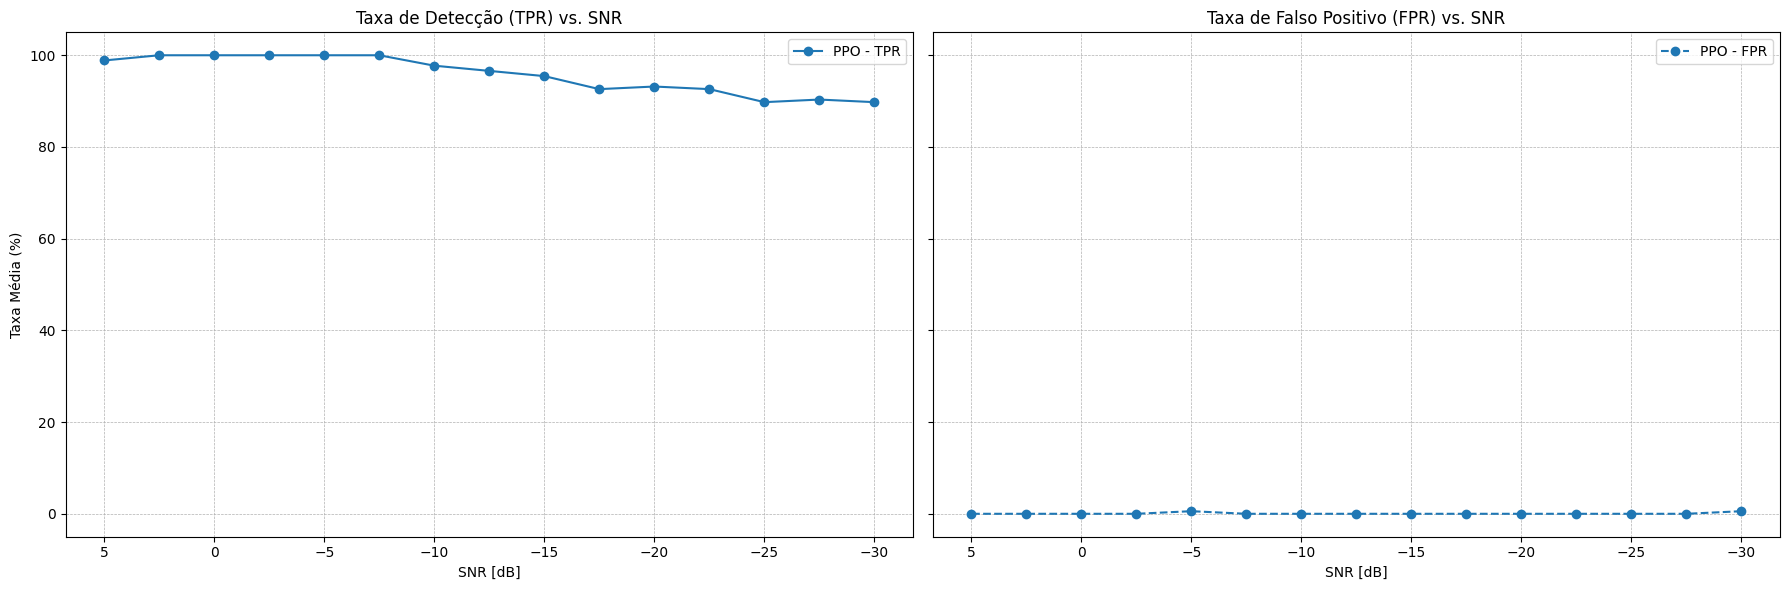


--- Avaliando modelo PPO em dados EXPERIMENTAIS com retreinamento ---
  Intensidade 70 dB -> TPR: 30.36%, FPR: 0.00%
  Intensidade 60 dB -> TPR: 75.71%, FPR: 2.59%
  Intensidade 50 dB -> TPR: 47.44%, FPR: 2.77%
  Intensidade 40 dB -> TPR: 36.65%, FPR: 0.49%
  Intensidade 30 dB -> TPR: 31.36%, FPR: 0.00%
----------------------------------------


In [ ]:
# -*- coding: utf-8 -*-
"""
Notebook Refatorado v15 para Treinamento de Modelo PPO com Engenharia de Features Configurável.

Esta versão foca exclusivamente no modelo PPO e introduz um sistema flexível
para engenharia de features. Os usuários podem definir uma lista de features
e suas transformações (simples, média móvel, soma/média cumulativa) para construir
o espaço de observação do agente de RL.
"""

# %% [markdown]
# # Treinamento de Modelo PPO com Features Configuráveis (v15)
#
# # Este notebook treina e avalia um modelo PPO, permitindo a seleção e transformação customizada de features para compor o estado de observação do agente.

# %% [code]
# Importações essenciais
import pickle
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import BaseCallback
import torch as th
import matplotlib.pyplot as plt
import h5py
import warnings

# Ignorar alguns avisos comuns para manter a saída limpa
warnings.filterwarnings("ignore", category=UserWarning)

# %% [markdown]
# ## Parâmetros de Controle e Configuração de Features

# %% [code]
# #####################################################################
# FEATURE ENGINEERING CONFIGURATION (AJUSTÁVEL PELO USUÁRIO)
# #####################################################################
# Defina as features e transformações a serem usadas pelo agente.
# Formato: ('nome_da_feature', 'tipo_transformacao', {parâmetros})
#
# Nomes de Features Disponíveis: 'MSC', 'CSM', 'TFG', 'TFL', 'SNR_meas', 'MAG_freq', 'PHI_freq'
# Feature Especial: 'timestamp'
#
# Tipos de Transformação:
# - 'simple': Valor atual da feature.
# - 'moving_mean': Média móvel. Requer {'window_size': N}.
# - 'cumsum': Soma cumulativa desde o início do episódio.
# - 'cummean': Média cumulativa desde o início do episódio.
# #####################################################################

FEATURE_NAMES = ['MSC', 'CSM', 'TFG', 'TFL', 'SNR_meas', 'MAG_freq', 'PHI_freq']

# FEATURE_CONFIG = [
#     # --- Features Simples (valor atual) ---
#     ('MSC', 'simple', {}),
#     ('CSM', 'simple', {}),
#     ('TFL', 'simple', {}),
#     ('SNR_meas', 'simple', {}),
#     ('MAG_freq', 'simple', {}),

#     # --- Features de Média Móvel ---
#     ('MSC', 'moving_mean', {'window_size': 18}),
#     ('CSM', 'moving_mean', {'window_size': 18}),
#     ('TFL', 'moving_mean', {'window_size': 18}),
#     ('MAG_freq', 'moving_mean', {'window_size': 18}),

#     # --- Feature de Tempo ---
#     ('timestamp', 'simple', {})
# ]

FEATURE_CONFIG = [
    # --- Features Simples (valor atual) ---
    ('MSC', 'simple', {}),
    ('CSM', 'simple', {}),
    ('TFL', 'simple', {}),
    ('SNR_meas', 'simple', {}),
    ('MAG_freq', 'simple', {}),

    # --- Features de Média Móvel ---
    ('MSC', 'moving_mean', {'window_size': 18}),
    ('CSM', 'moving_mean', {'window_size': 18}),
    ('TFL', 'moving_mean', {'window_size': 18}),
    ('MAG_freq', 'moving_mean', {'window_size': 18}),

    ('MSC', 'cumsum',{}),
    ('CSM', 'cumsum',{}),
    ('TFL', 'cumsum',{}),
    ('MAG_freq', 'cumsum',{}),

    # --- Feature de Tempo ---
    ('timestamp', 'simple', {})
]



# #####################################################################
# MODO DE EXECUÇÃO E PARÂMETROS GLOBAIS
# #####################################################################
DRY_RUN = False # Mude para False para uma execução completa

if DRY_RUN:
    print("--- EXECUTANDO EM MODO DRY RUN (TESTE RÁPIDO) ---")
    TOTAL_TIMESTEPS_TREINO, EVAL_SIM_TIMESTEPS = 2500, 1000
    VERBOSE_LEVEL, VERBOSE_FREQ, SB3_LOG_FREQ = 1, 5, 10
else:
    print("--- EXECUTANDO EM MODO COMPLETO ---")
    TOTAL_TIMESTEPS_TREINO, EVAL_SIM_TIMESTEPS = 5000, 2500
    VERBOSE_LEVEL, VERBOSE_FREQ, SB3_LOG_FREQ = 1, 25, 50

# #####################################################################
# CAMINHOS E CONSTANTES
# #####################################################################
HDF5_SIMULATED_FILEPATH = '../data/train.hdf5'
EXPERIMENTAL_FEATURES_FILE = '../data/experimental_features.hdf5'
NUM_SIGNAL_FREQS = 8

# %% [markdown]
# ## Carga e Preparação dos Dados (HDF5)

# %% [code]
def load_and_adapt_hdf5_data(sim_path, exp_path):
    """Carrega dados HDF5 e os adapta para o formato do notebook original."""
    c_states_simulado = {}
    c_states_experimental = {}

    print(f"Carregando dados simulados de: {sim_path}")
    with h5py.File(sim_path, 'r') as f:
        snr_keys = sorted([key for key in f.keys() if 'snr' in key], key=lambda x: float(x.split('_')[1]))
        for key in snr_keys:
            snr_val = float(key.split('_')[1])
            data = f[key]['metrics'][:]
            # Formato adaptado: (trials, steps, features) - Remove a dimensão extra de 'window'
            c_states_simulado[snr_val] = data

    print(f"Carregando dados experimentais de: {exp_path}")
    intensidades_map = {70:(4,1), 60:(4,2), 50:(4,3), 40:(4,4), 30:(4,5)}
    try:
        with h5py.File(exp_path, 'r') as f:
            first_volunteer = list(f.keys())[0]
            intensity_keys = sorted(f[first_volunteer].keys())
            for i, intensity_key in enumerate(list(intensidades_map.values())):
                if i < len(intensity_keys):
                    h5_intensity_key = intensity_keys[i]
                    data = f[first_volunteer][h5_intensity_key]['metrics'][:]
                    # Transpõe para (steps, features, trials) para simular (freqs, measures, windows)
                    c_states_experimental[intensity_key] = data.transpose(1, 2, 0)
    except (FileNotFoundError, IndexError):
        print(f"Aviso: Arquivo de dados experimentais '{exp_path}' não encontrado. Avaliação experimental será pulada.")

    return c_states_simulado, c_states_experimental

c_states_simulado, c_states_experimental = load_and_adapt_hdf5_data(
    HDF5_SIMULATED_FILEPATH, EXPERIMENTAL_FEATURES_FILE
)

# Validação e Limpeza
def clean_data_dict(data_dict):
    for key, array in data_dict.items():
        if np.isnan(array).any() or np.isinf(array).any():
            print(f"Aviso: Limpando valores inválidos para a chave '{key}'.")
            data_dict[key] = np.nan_to_num(array, nan=0.0, posinf=0.0, neginf=0.0)
    return data_dict

print("\nValidando e limpando dados...")
c_states_simulado = clean_data_dict(c_states_simulado)
c_states_experimental = clean_data_dict(c_states_experimental)
print("Validação completa.")

# %% [code]
# FUNÇÃO DE NORMALIZAÇÃO
def my_norm(val, min_val=0, max_val=3):
    # Evita divisão por zero se max_val == min_val
    if max_val == min_val:
        return val - min_val
    return (val - min_val) / (max_val - min_val)

# %% [markdown]
# ## Ambientes Gymnasium com Engenharia de Features Dinâmica

# %% [code]
class CustomLoggingCallback(BaseCallback):
    def __init__(self, log_freq: int, verbose=0):
        super().__init__(verbose)
        self.log_freq, self.episode_count = log_freq, 0
    def _on_step(self) -> bool:
        if any(self.locals["dones"]):
            self.episode_count += 1
            if self.episode_count % self.log_freq == 0 and self.logger.name_to_value:
                print(f"--- Logs da Biblioteca (Episódio {self.episode_count}) ---")
                for key, value in self.logger.name_to_value.items():
                    print(f"  {key}: {value:.4f}")
                print("---------------------------------------")
        return True

class FeatureEngineEnv(gym.Env):
    """Classe base para ambientes que usam a engenharia de features configurável."""
    def __init__(self, data, feature_config, feature_names):
        super().__init__()
        self.data = data
        self.feature_config = feature_config
        self.feature_names = feature_names
        self.feature_indices = {name: i for i, name in enumerate(feature_names)}

        # Calcula o tamanho do espaço de observação
        num_output_features = 0
        for name, _, _ in self.feature_config:
            if name == 'timestamp':
                num_output_features += 1
            else: # Assume que cada feature base contribui com 1 valor
                num_output_features += 1

        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(num_output_features,), dtype=np.float32
        )

    def _generate_state(self, history_data, current_step, total_steps):
        state_features = []
        for feature, transform, params in self.feature_config:
            if feature == 'timestamp':
                # Normaliza o timestamp
                state_features.append(current_step / total_steps if total_steps > 0 else 0)
                continue

            feature_idx = self.feature_indices[feature]
            # Seleciona a coluna da feature e o histórico até o passo atual
            feature_history = history_data[:current_step + 1, feature_idx]

            if transform == 'simple':
                val = feature_history[-1]
            elif transform == 'moving_mean':
                window = params.get('window_size', 10)
                start = max(0, len(feature_history) - window)
                val = np.mean(feature_history[start:])
            elif transform == 'cumsum':
                val = np.sum(feature_history)
            elif transform == 'cummean':
                val = np.mean(feature_history)
            else:
                raise ValueError(f"Transformação desconhecida: {transform}")

            state_features.append(my_norm(val)) # Normaliza as features de dados

        return np.array(state_features, dtype=np.float32)

class SimTrainingEnv(FeatureEngineEnv):
    def __init__(self, data, feature_config, feature_names, verbose_level=0, verbose_freq=10):
        super().__init__(data, feature_config, feature_names)
        self.verbose_level, self.verbose_freq = verbose_level, verbose_freq
        self.episodes, self.frequencies, self.windows = data.shape[0]-1, data.shape[1]-1, data.shape[2]-1
        self.episode_count = -1
        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.episode_count += 1
        self.current_episode = self.episode_count % (self.episodes + 1)
        self.current_window, self.current_frequency = 0, 0
        self.current_trial_data = self.data[self.current_episode, :, :] # Dados do trial atual
        self.false_positives, self.true_positives = 0, 0
        self.tpr_hist, self.fpr_hist = [], []
        return self._get_state(), {'tp_rate': np.nan, 'fp_rate': np.nan}

    def step(self, action):
        should_detect = self.current_frequency < NUM_SIGNAL_FREQS
        tp,fp,fn,tn = 0,0,0,0
        if action==1:
            if should_detect: self.true_positives+=1; tp=1
            else: self.false_positives+=1; fp=1
        else:
            if should_detect: fn=1
            else: tn=1
        reward = tp - 1.5*fp - fn + tn
        self.current_frequency += 1
        terminated, info = False, {}
        if self.current_frequency > self.frequencies:
            num_noise_freqs = self.frequencies + 1 - NUM_SIGNAL_FREQS
            tp_rate = 100 * self.true_positives / NUM_SIGNAL_FREQS if NUM_SIGNAL_FREQS > 0 else 0
            fp_rate = 100 * self.false_positives / num_noise_freqs if num_noise_freqs > 0 else 0
            self.tpr_hist.append(tp_rate); self.fpr_hist.append(fp_rate)
            self.current_window += 1
            self.current_frequency, self.true_positives, self.false_positives = 0,0,0
            if self.current_window > self.windows:
                terminated = True
                mean_tpr = np.mean(self.tpr_hist) if self.tpr_hist else 0
                mean_fpr = np.mean(self.fpr_hist) if self.fpr_hist else 0
                reward = ((mean_tpr/100)**2) - ((mean_fpr/100)**2)
                info = {'tp_rate': round(mean_tpr,2), 'fp_rate': round(mean_fpr,2)}
                if self.verbose_level > 0 and self.episode_count % self.verbose_freq == 0:
                    print(f"--- Resumo do Ambiente (Episódio {self.episode_count}) ---")
                    print(f"  TPR Final: {info.get('tp_rate',0):.2f}%, FPR Final: {info.get('fp_rate',0):.2f}%, Recompensa Final: {reward:.2f}")
            else: # Atualiza os dados do trial para a nova janela
                self.current_trial_data = self.data[self.current_episode, :, :]

        return self._get_state(), reward, terminated, False, info

    def _get_state(self):
        return self._generate_state(self.current_trial_data, self.current_frequency, self.frequencies)

class ExpEvaluationEnv(FeatureEngineEnv):
    def __init__(self, data, feature_config, feature_names):
        super().__init__(data, feature_config, feature_names)
        self.frequencies, self.windows = data.shape[0]-1, data.shape[2]-1
        self.current_window = -1
        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_window = (self.current_window + 1) % (self.windows + 1)
        self.current_trial_data = self.data[:, :, self.current_window]
        self.current_frequency, self.true_positives, self.false_positives = 0,0,0
        return self._get_state(), self._get_info()

    def step(self, action):
        should_detect = self.current_frequency < NUM_SIGNAL_FREQS
        if action == 1:
            if should_detect: self.true_positives += 1
            else: self.false_positives += 1
        self.current_frequency += 1
        terminated = self.current_frequency > self.frequencies
        reward = 1 if (action==1 and should_detect) or (action==0 and not should_detect) else -5
        return self._get_state(), reward, terminated, False, self._get_info() if terminated else {}

    def _get_state(self):
        return self._generate_state(self.current_trial_data, self.current_frequency, self.frequencies)

    def _get_info(self):
        num_noise_freqs = self.frequencies + 1 - NUM_SIGNAL_FREQS
        tp_rate = 100 * self.true_positives / NUM_SIGNAL_FREQS if NUM_SIGNAL_FREQS > 0 else 0
        fp_rate = 100 * self.false_positives / num_noise_freqs if num_noise_freqs > 0 else 0
        return {'tp_rate': tp_rate, 'fp_rate': fp_rate}

# %% [markdown]
# # 1. Treinamento do Modelo PPO
# %% [code]
def train_ppo_model(policy, data, timesteps, model_name, v_level, v_freq, log_freq):
    print("--- Treinando modelo PPO ---")
    env = DummyVecEnv([lambda: SimTrainingEnv(data, FEATURE_CONFIG, FEATURE_NAMES, v_level, v_freq)])
    policy_kwargs = dict(activation_fn=th.nn.ReLU, net_arch=dict(pi=[64, 64], vf=[64, 64]))
    model = PPO(policy, env, verbose=0, policy_kwargs=policy_kwargs)
    model.learn(total_timesteps=timesteps, callback=CustomLoggingCallback(log_freq=log_freq))
    model.save(model_name)
    print(f"Modelo salvo como {model_name}\n")

snr_treino = 0.0
if snr_treino in c_states_simulado:
    dados_treino = c_states_simulado[snr_treino]
    train_ppo_model('MlpPolicy', dados_treino, TOTAL_TIMESTEPS_TREINO, 'modelo_ppo.zip', VERBOSE_LEVEL, VERBOSE_FREQ, SB3_LOG_FREQ)
else:
    print(f"ERRO: SNR de treino {snr_treino} dB não encontrado. Pulando treinamento.")

# %% [markdown]
# # 2. Avaliação em Dados Simulados (vs. SNR)
# %% [code]
def evaluate_on_sim_data(model, data, total_timesteps):
    env = SimTrainingEnv(data, FEATURE_CONFIG, FEATURE_NAMES)
    obs, _ = env.reset()
    tpr_list, fpr_list = [], []
    for _ in range(total_timesteps):
        action, _ = model.predict(obs, deterministic=True)
        obs, _, terminated, _, info = env.step(action)
        if terminated:
            if 'tp_rate' in info and not np.isnan(info['tp_rate']):
                tpr_list.append(info['tp_rate']); fpr_list.append(info['fp_rate'])
            obs, _ = env.reset()
    if not tpr_list: return np.nan, np.nan
    return np.nanmean(tpr_list), np.nanmean(fpr_list)

results = {"PPO": {"tpr": [], "fpr": []}}
snr_list = sorted(c_states_simulado.keys())
if DRY_RUN: snr_list = [snr for snr in snr_list if snr in [0.0, -5.0]]

print("--- Avaliando modelo PPO em dados SIMULADOS ---")
for snr in snr_list:
    print(f"Avaliando SNR: {snr} dB")
    try:
        model = PPO.load('modelo_ppo.zip')
        tpr, fpr = evaluate_on_sim_data(model, c_states_simulado[snr], EVAL_SIM_TIMESTEPS)
        results["PPO"]["tpr"].append(tpr); results["PPO"]["fpr"].append(fpr)
    except FileNotFoundError:
        print("Aviso: 'modelo_ppo.zip' não encontrado. Pulando avaliação.")
        break

# Plotagem
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6), sharey=True)
ax1.plot(snr_list, results["PPO"]["tpr"], 'o-', label='PPO - TPR')
ax1.set_title('Taxa de Detecção (TPR) vs. SNR'); ax1.set_xlabel('SNR [dB]'); ax1.set_ylabel('Taxa Média (%)')
ax1.grid(True, which='both', linestyle='--', linewidth=0.5); ax1.legend(); ax1.invert_xaxis()

ax2.plot(snr_list, results["PPO"]["fpr"], 'o--', label='PPO - FPR', color='C0')
ax2.set_title('Taxa de Falso Positivo (FPR) vs. SNR'); ax2.set_xlabel('SNR [dB]')
ax2.grid(True, which='both', linestyle='--', linewidth=0.5); ax2.legend(); ax2.invert_xaxis()

plt.tight_layout()
plt.savefig('performance_vs_snr_v15_features.png')
print(f"\nGráfico 'performance_vs_snr_v15_features.png' foi salvo.")
plt.show()

# %% [markdown]
# # 3. Avaliação com Retreinamento em Dados Experimentais
# %% [code]
def evaluate_on_exp_data(model, data):
    env = ExpEvaluationEnv(data, FEATURE_CONFIG, FEATURE_NAMES)
    tpr_list, fpr_list = [], []
    for _ in range(data.shape[2]): # Itera sobre as 'windows' (trials)
        obs, info = env.reset()
        done = False
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, _, done, _, info = env.step(action)
        tpr_list.append(info['tp_rate']); fpr_list.append(info['fp_rate'])
    return np.mean(tpr_list), np.mean(fpr_list)

intensidades_map = {70:(4,1), 60:(4,2), 50:(4,3), 40:(4,4), 30:(4,5)}
if DRY_RUN: intensidades_map = {70:(4,1), 40:(4,4)}

if not c_states_experimental:
    print("\n--- Nenhum dado experimental carregado. Pulando avaliação com retreinamento. ---")
else:
    print("\n--- Avaliando modelo PPO em dados EXPERIMENTAIS com retreinamento ---")
    try:
        # Verifica se o modelo base existe antes de entrar no loop
        _ = PPO.load('modelo_ppo.zip')
        
        for intensidade_db, data_key in intensidades_map.items():
            if data_key not in c_states_experimental:
                print(f"  Aviso: Chave {data_key} para intensidade {intensidade_db} dB não encontrada. Pulando.")
                continue

            dados_exp = c_states_experimental[data_key]
            dados_retreino, dados_avaliacao = dados_exp[:, :, :1], dados_exp[:, :, 1:]

            model = PPO.load('modelo_ppo.zip')
            env_retreino = DummyVecEnv([lambda: ExpEvaluationEnv(dados_retreino, FEATURE_CONFIG, FEATURE_NAMES)])
            model.set_env(env_retreino)
            model.learn(total_timesteps=dados_retreino.shape[0] * dados_retreino.shape[2])

            if dados_avaliacao.shape[2] > 0:
                tpr, fpr = evaluate_on_exp_data(model, dados_avaliacao)
                print(f"  Intensidade {intensidade_db} dB -> TPR: {tpr:.2f}%, FPR: {fpr:.2f}%")
            else:
                print(f"  Intensidade {intensidade_db} dB -> Apenas 1 trial, sem dados para avaliação separada.")
        print("-" * 40)
    except FileNotFoundError:
        print("Aviso: 'modelo_ppo.zip' não encontrado. Pulando avaliação experimental.")

--- EXECUTANDO EM MODO COMPLETO ---
Carregando dados simulados de: ../data/train.hdf5
Carregando dados experimentais de: ../data/experimental_features.hdf5

Validando e limpando dados...
Validação completa.
--- Treinando modelo PPO ---
Modelo salvo como modelo_ppo.zip

--- Avaliando modelo PPO em dados SIMULADOS ---
Avaliando SNR: -30.0 dB
Avaliando SNR: -27.5 dB
Avaliando SNR: -25.0 dB
Avaliando SNR: -22.5 dB
Avaliando SNR: -20.0 dB
Avaliando SNR: -17.5 dB
Avaliando SNR: -15.0 dB
Avaliando SNR: -12.5 dB
Avaliando SNR: -10.0 dB
Avaliando SNR: -7.5 dB
Avaliando SNR: -5.0 dB
Avaliando SNR: -2.5 dB
Avaliando SNR: 0.0 dB
Avaliando SNR: 2.5 dB
Avaliando SNR: 5.0 dB

Gráfico 'performance_vs_snr_v15_features.png' foi salvo.


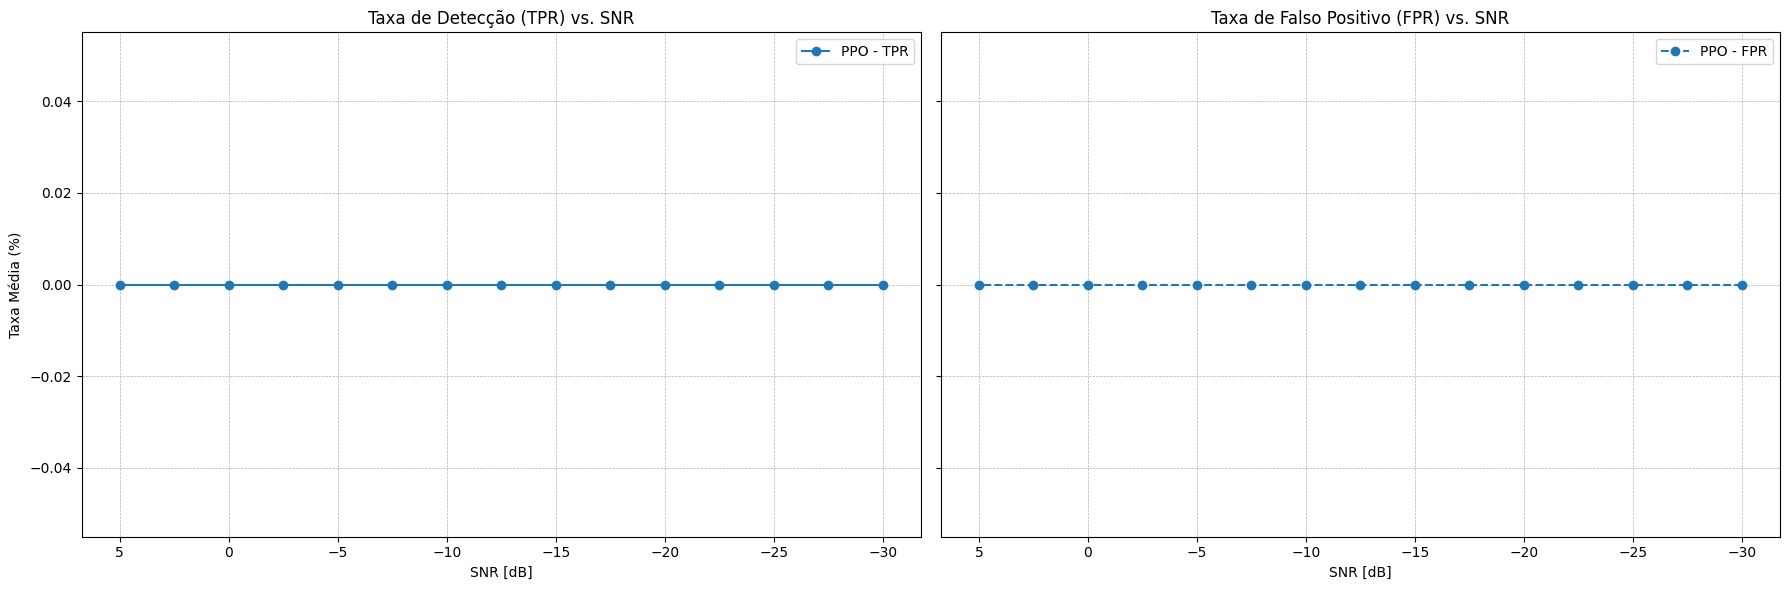


--- Avaliando modelo PPO em dados EXPERIMENTAIS com retreinamento ---
  Intensidade 70 dB -> TPR: 61.02%, FPR: 1.33%
  Intensidade 60 dB -> TPR: 51.42%, FPR: 0.26%
  Intensidade 50 dB -> TPR: 57.05%, FPR: 0.76%
  Intensidade 40 dB -> TPR: 46.05%, FPR: 0.00%
  Intensidade 30 dB -> TPR: 39.69%, FPR: 0.00%
----------------------------------------


: 

In [ ]:
# -*- coding: utf-8 -*-
"""
Notebook Refatorado v15 para Treinamento de Modelo PPO com Engenharia de Features Configurável.

Esta versão foca exclusivamente no modelo PPO e introduz um sistema flexível
para engenharia de features. Os usuários podem definir uma lista de features
e suas transformações (simples, média móvel, soma/média cumulativa) para construir
o espaço de observação do agente de RL.
"""

# %% [markdown]
# # Treinamento de Modelo PPO com Features Configuráveis (v15)
#
# # Este notebook treina e avalia um modelo PPO, permitindo a seleção e transformação customizada de features para compor o estado de observação do agente.

# %% [code]
# Importações essenciais
import pickle
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import BaseCallback
import torch as th
import matplotlib.pyplot as plt
import h5py
import warnings

# Ignorar alguns avisos comuns para manter a saída limpa
warnings.filterwarnings("ignore", category=UserWarning)

# %% [markdown]
# ## Parâmetros de Controle e Configuração de Features

# %% [code]
# #####################################################################
# FEATURE ENGINEERING CONFIGURATION (AJUSTÁVEL PELO USUÁRIO)
# #####################################################################
# Defina as features e transformações a serem usadas pelo agente.
# Formato: ('nome_da_feature', 'tipo_transformacao', {parâmetros})
#
# Nomes de Features Disponíveis: 'MSC', 'CSM', 'TFG', 'TFL', 'SNR_meas', 'MAG_freq', 'PHI_freq'
# Feature Especial: 'timestamp'
#
# Tipos de Transformação:
# - 'simple': Valor atual da feature.
# - 'moving_mean': Média móvel. Requer {'window_size': N}.
# - 'cumsum': Soma cumulativa desde o início do episódio.
# - 'cummean': Média cumulativa desde o início do episódio.
# #####################################################################

FEATURE_NAMES = ['MSC', 'CSM', 'TFG', 'TFL', 'SNR_meas', 'MAG_freq', 'PHI_freq']

# FEATURE_CONFIG = [
#     # --- Features Simples (valor atual) ---
#     ('MSC', 'simple', {}),
#     ('CSM', 'simple', {}),
#     ('TFL', 'simple', {}),
#     ('SNR_meas', 'simple', {}),
#     ('MAG_freq', 'simple', {}),

#     # --- Features de Média Móvel ---
#     ('MSC', 'moving_mean', {'window_size': 18}),
#     ('CSM', 'moving_mean', {'window_size': 18}),
#     ('TFL', 'moving_mean', {'window_size': 18}),
#     ('MAG_freq', 'moving_mean', {'window_size': 18}),

#     # --- Feature de Tempo ---
#     ('timestamp', 'simple', {})
# ]

FEATURE_CONFIG = [
    # --- Features Simples (valor atual) ---
    ('MSC', 'simple', {}),
    ('CSM', 'simple', {}),
    ('TFL', 'simple', {}),
    ('SNR_meas', 'simple', {}),
    ('MAG_freq', 'simple', {}),

    # --- Features de Média Móvel ---
    ('MSC', 'moving_mean', {'window_size': 18}),
    ('CSM', 'moving_mean', {'window_size': 18}),
    ('TFL', 'moving_mean', {'window_size': 18}),
    ('MAG_freq', 'moving_mean', {'window_size': 18}),

    ('MSC', 'cumsum',{}),
    ('CSM', 'cumsum',{}),
    ('TFL', 'cumsum',{}),
    ('MAG_freq', 'cumsum',{}),

    # --- Feature de Tempo ---
    ('timestamp', 'simple', {})
]



# #####################################################################
# MODO DE EXECUÇÃO E PARÂMETROS GLOBAIS
# #####################################################################
DRY_RUN = False # Mude para False para uma execução completa

if DRY_RUN:
    print("--- EXECUTANDO EM MODO DRY RUN (TESTE RÁPIDO) ---")
    TOTAL_TIMESTEPS_TREINO, EVAL_SIM_TIMESTEPS = 2500, 1000
    VERBOSE_LEVEL, VERBOSE_FREQ, SB3_LOG_FREQ = 1, 5, 10
else:
    print("--- EXECUTANDO EM MODO COMPLETO ---")
    TOTAL_TIMESTEPS_TREINO, EVAL_SIM_TIMESTEPS = 5, 2500
    VERBOSE_LEVEL, VERBOSE_FREQ, SB3_LOG_FREQ = 1, 25, 50

# #####################################################################
# CAMINHOS E CONSTANTES
# #####################################################################
HDF5_SIMULATED_FILEPATH = '../data/train.hdf5'
EXPERIMENTAL_FEATURES_FILE = '../data/experimental_features.hdf5'
NUM_SIGNAL_FREQS = 8

# %% [markdown]
# ## Carga e Preparação dos Dados (HDF5)

# %% [code]
def load_and_adapt_hdf5_data(sim_path, exp_path):
    """Carrega dados HDF5 e os adapta para o formato do notebook original."""
    c_states_simulado = {}
    c_states_experimental = {}

    print(f"Carregando dados simulados de: {sim_path}")
    with h5py.File(sim_path, 'r') as f:
        snr_keys = sorted([key for key in f.keys() if 'snr' in key], key=lambda x: float(x.split('_')[1]))
        for key in snr_keys:
            snr_val = float(key.split('_')[1])
            data = f[key]['metrics'][:]
            # Formato adaptado: (trials, steps, features) - Remove a dimensão extra de 'window'
            c_states_simulado[snr_val] = data

    print(f"Carregando dados experimentais de: {exp_path}")
    intensidades_map = {70:(4,1), 60:(4,2), 50:(4,3), 40:(4,4), 30:(4,5)}
    try:
        with h5py.File(exp_path, 'r') as f:
            first_volunteer = list(f.keys())[0]
            intensity_keys = sorted(f[first_volunteer].keys())
            for i, intensity_key in enumerate(list(intensidades_map.values())):
                if i < len(intensity_keys):
                    h5_intensity_key = intensity_keys[i]
                    data = f[first_volunteer][h5_intensity_key]['metrics'][:]
                    # Transpõe para (steps, features, trials) para simular (freqs, measures, windows)
                    c_states_experimental[intensity_key] = data.transpose(1, 2, 0)
    except (FileNotFoundError, IndexError):
        print(f"Aviso: Arquivo de dados experimentais '{exp_path}' não encontrado. Avaliação experimental será pulada.")

    return c_states_simulado, c_states_experimental

c_states_simulado, c_states_experimental = load_and_adapt_hdf5_data(
    HDF5_SIMULATED_FILEPATH, EXPERIMENTAL_FEATURES_FILE
)

# Validação e Limpeza
def clean_data_dict(data_dict):
    for key, array in data_dict.items():
        if np.isnan(array).any() or np.isinf(array).any():
            print(f"Aviso: Limpando valores inválidos para a chave '{key}'.")
            data_dict[key] = np.nan_to_num(array, nan=0.0, posinf=0.0, neginf=0.0)
    return data_dict

print("\nValidando e limpando dados...")
c_states_simulado = clean_data_dict(c_states_simulado)
c_states_experimental = clean_data_dict(c_states_experimental)
print("Validação completa.")

# %% [code]
# FUNÇÃO DE NORMALIZAÇÃO
def my_norm(val, min_val=0, max_val=3):
    # Evita divisão por zero se max_val == min_val
    if max_val == min_val:
        return val - min_val
    return (val - min_val) / (max_val - min_val)

# %% [markdown]
# ## Ambientes Gymnasium com Engenharia de Features Dinâmica

# %% [code]
class CustomLoggingCallback(BaseCallback):
    def __init__(self, log_freq: int, verbose=0):
        super().__init__(verbose)
        self.log_freq, self.episode_count = log_freq, 0
    def _on_step(self) -> bool:
        if any(self.locals["dones"]):
            self.episode_count += 1
            if self.episode_count % self.log_freq == 0 and self.logger.name_to_value:
                print(f"--- Logs da Biblioteca (Episódio {self.episode_count}) ---")
                for key, value in self.logger.name_to_value.items():
                    print(f"  {key}: {value:.4f}")
                print("---------------------------------------")
        return True

class FeatureEngineEnv(gym.Env):
    """Classe base para ambientes que usam a engenharia de features configurável."""
    def __init__(self, data, feature_config, feature_names):
        super().__init__()
        self.data = data
        self.feature_config = feature_config
        self.feature_names = feature_names
        self.feature_indices = {name: i for i, name in enumerate(feature_names)}

        # Calcula o tamanho do espaço de observação
        num_output_features = 0
        for name, _, _ in self.feature_config:
            if name == 'timestamp':
                num_output_features += 1
            else: # Assume que cada feature base contribui com 1 valor
                num_output_features += 1

        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(num_output_features,), dtype=np.float32
        )

    def _generate_state(self, history_data, current_step, total_steps):
        state_features = []
        for feature, transform, params in self.feature_config:
            if feature == 'timestamp':
                # Normaliza o timestamp
                state_features.append(current_step / total_steps if total_steps > 0 else 0)
                continue

            feature_idx = self.feature_indices[feature]
            # Seleciona a coluna da feature e o histórico até o passo atual
            feature_history = history_data[:current_step + 1, feature_idx]

            if transform == 'simple':
                val = feature_history[-1]
            elif transform == 'moving_mean':
                window = params.get('window_size', 10)
                start = max(0, len(feature_history) - window)
                val = np.mean(feature_history[start:])
            elif transform == 'cumsum':
                val = np.sum(feature_history)
            elif transform == 'cummean':
                val = np.mean(feature_history)
            else:
                raise ValueError(f"Transformação desconhecida: {transform}")

            state_features.append(my_norm(val)) # Normaliza as features de dados

        return np.array(state_features, dtype=np.float32)

class SimTrainingEnv(FeatureEngineEnv):
    def __init__(self, data, feature_config, feature_names, verbose_level=0, verbose_freq=10):
        super().__init__(data, feature_config, feature_names)
        self.verbose_level, self.verbose_freq = verbose_level, verbose_freq
        self.episodes, self.frequencies, self.windows = data.shape[0]-1, data.shape[1]-1, data.shape[2]-1
        self.episode_count = -1
        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.episode_count += 1
        self.current_episode = self.episode_count % (self.episodes + 1)
        self.current_window, self.current_frequency = 0, 0
        self.current_trial_data = self.data[self.current_episode, :, :] # Dados do trial atual
        self.false_positives, self.true_positives = 0, 0
        self.tpr_hist, self.fpr_hist = [], []
        return self._get_state(), {'tp_rate': np.nan, 'fp_rate': np.nan}

    def step(self, action):
        should_detect = self.current_frequency < NUM_SIGNAL_FREQS
        tp,fp,fn,tn = 0,0,0,0
        if action==1:
            if should_detect: self.true_positives+=1; tp=1
            else: self.false_positives+=1; fp=1
        else:
            if should_detect: fn=1
            else: tn=1
        reward = tp - 1.5*fp - fn + tn
        self.current_frequency += 1
        terminated, info = False, {}
        if self.current_frequency > self.frequencies:
            num_noise_freqs = self.frequencies + 1 - NUM_SIGNAL_FREQS
            tp_rate = 100 * self.true_positives / NUM_SIGNAL_FREQS if NUM_SIGNAL_FREQS > 0 else 0
            fp_rate = 100 * self.false_positives / num_noise_freqs if num_noise_freqs > 0 else 0
            self.tpr_hist.append(tp_rate); self.fpr_hist.append(fp_rate)
            self.current_window += 1
            self.current_frequency, self.true_positives, self.false_positives = 0,0,0
            if self.current_window > self.windows:
                terminated = True
                mean_tpr = np.mean(self.tpr_hist) if self.tpr_hist else 0
                mean_fpr = np.mean(self.fpr_hist) if self.fpr_hist else 0
                reward = ((mean_tpr/100)**2) - ((mean_fpr/100)**2)
                info = {'tp_rate': round(mean_tpr,2), 'fp_rate': round(mean_fpr,2)}
                if self.verbose_level > 0 and self.episode_count % self.verbose_freq == 0:
                    print(f"--- Resumo do Ambiente (Episódio {self.episode_count}) ---")
                    print(f"  TPR Final: {info.get('tp_rate',0):.2f}%, FPR Final: {info.get('fp_rate',0):.2f}%, Recompensa Final: {reward:.2f}")
            else: # Atualiza os dados do trial para a nova janela
                self.current_trial_data = self.data[self.current_episode, :, :]

        return self._get_state(), reward, terminated, False, info

    def _get_state(self):
        return self._generate_state(self.current_trial_data, self.current_frequency, self.frequencies)

class ExpEvaluationEnv(FeatureEngineEnv):
    def __init__(self, data, feature_config, feature_names):
        super().__init__(data, feature_config, feature_names)
        self.frequencies, self.windows = data.shape[0]-1, data.shape[2]-1
        self.current_window = -1
        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_window = (self.current_window + 1) % (self.windows + 1)
        self.current_trial_data = self.data[:, :, self.current_window]
        self.current_frequency, self.true_positives, self.false_positives = 0,0,0
        return self._get_state(), self._get_info()

    def step(self, action):
        should_detect = self.current_frequency < NUM_SIGNAL_FREQS
        if action == 1:
            if should_detect: self.true_positives += 1
            else: self.false_positives += 1
        self.current_frequency += 1
        terminated = self.current_frequency > self.frequencies
        reward = 1 if (action==1 and should_detect) or (action==0 and not should_detect) else -5
        return self._get_state(), reward, terminated, False, self._get_info() if terminated else {}

    def _get_state(self):
        return self._generate_state(self.current_trial_data, self.current_frequency, self.frequencies)

    def _get_info(self):
        num_noise_freqs = self.frequencies + 1 - NUM_SIGNAL_FREQS
        tp_rate = 100 * self.true_positives / NUM_SIGNAL_FREQS if NUM_SIGNAL_FREQS > 0 else 0
        fp_rate = 100 * self.false_positives / num_noise_freqs if num_noise_freqs > 0 else 0
        return {'tp_rate': tp_rate, 'fp_rate': fp_rate}

# %% [markdown]
# # 1. Treinamento do Modelo PPO
# %% [code]
def train_ppo_model(policy, data, timesteps, model_name, v_level, v_freq, log_freq):
    print("--- Treinando modelo PPO ---")
    env = DummyVecEnv([lambda: SimTrainingEnv(data, FEATURE_CONFIG, FEATURE_NAMES, v_level, v_freq)])
    policy_kwargs = dict(activation_fn=th.nn.ReLU, net_arch=dict(pi=[64, 64], vf=[64, 64]))
    model = PPO(policy, env, verbose=0, policy_kwargs=policy_kwargs)
    model.learn(total_timesteps=timesteps, callback=CustomLoggingCallback(log_freq=log_freq))
    model.save(model_name)
    print(f"Modelo salvo como {model_name}\n")

snr_treino = 0.0
if snr_treino in c_states_simulado:
    dados_treino = c_states_simulado[snr_treino]
    train_ppo_model('MlpPolicy', dados_treino, TOTAL_TIMESTEPS_TREINO, 'modelo_ppo.zip', VERBOSE_LEVEL, VERBOSE_FREQ, SB3_LOG_FREQ)
else:
    print(f"ERRO: SNR de treino {snr_treino} dB não encontrado. Pulando treinamento.")

# %% [markdown]
# # 2. Avaliação em Dados Simulados (vs. SNR)
# %% [code]
def evaluate_on_sim_data(model, data, total_timesteps):
    env = SimTrainingEnv(data, FEATURE_CONFIG, FEATURE_NAMES)
    obs, _ = env.reset()
    tpr_list, fpr_list = [], []
    for _ in range(total_timesteps):
        action, _ = model.predict(obs, deterministic=True)
        obs, _, terminated, _, info = env.step(action)
        if terminated:
            if 'tp_rate' in info and not np.isnan(info['tp_rate']):
                tpr_list.append(info['tp_rate']); fpr_list.append(info['fp_rate'])
            obs, _ = env.reset()
    if not tpr_list: return np.nan, np.nan
    return np.nanmean(tpr_list), np.nanmean(fpr_list)

results = {"PPO": {"tpr": [], "fpr": []}}
snr_list = sorted(c_states_simulado.keys())
if DRY_RUN: snr_list = [snr for snr in snr_list if snr in [0.0, -5.0]]

print("--- Avaliando modelo PPO em dados SIMULADOS ---")
for snr in snr_list:
    print(f"Avaliando SNR: {snr} dB")
    try:
        model = PPO.load('modelo_ppo.zip')
        tpr, fpr = evaluate_on_sim_data(model, c_states_simulado[snr], EVAL_SIM_TIMESTEPS)
        results["PPO"]["tpr"].append(tpr); results["PPO"]["fpr"].append(fpr)
    except FileNotFoundError:
        print("Aviso: 'modelo_ppo.zip' não encontrado. Pulando avaliação.")
        break

# Plotagem
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6), sharey=True)
ax1.plot(snr_list, results["PPO"]["tpr"], 'o-', label='PPO - TPR')
ax1.set_title('Taxa de Detecção (TPR) vs. SNR'); ax1.set_xlabel('SNR [dB]'); ax1.set_ylabel('Taxa Média (%)')
ax1.grid(True, which='both', linestyle='--', linewidth=0.5); ax1.legend(); ax1.invert_xaxis()

ax2.plot(snr_list, results["PPO"]["fpr"], 'o--', label='PPO - FPR', color='C0')
ax2.set_title('Taxa de Falso Positivo (FPR) vs. SNR'); ax2.set_xlabel('SNR [dB]')
ax2.grid(True, which='both', linestyle='--', linewidth=0.5); ax2.legend(); ax2.invert_xaxis()

plt.tight_layout()
plt.savefig('performance_vs_snr_v15_features.png')
print(f"\nGráfico 'performance_vs_snr_v15_features.png' foi salvo.")
plt.show()

# %% [markdown]
# # 3. Avaliação com Retreinamento em Dados Experimentais
# %% [code]
def evaluate_on_exp_data(model, data):
    env = ExpEvaluationEnv(data, FEATURE_CONFIG, FEATURE_NAMES)
    tpr_list, fpr_list = [], []
    for _ in range(data.shape[2]): # Itera sobre as 'windows' (trials)
        obs, info = env.reset()
        done = False
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, _, done, _, info = env.step(action)
        tpr_list.append(info['tp_rate']); fpr_list.append(info['fp_rate'])
    return np.mean(tpr_list), np.mean(fpr_list)

intensidades_map = {70:(4,1), 60:(4,2), 50:(4,3), 40:(4,4), 30:(4,5)}
if DRY_RUN: intensidades_map = {70:(4,1), 40:(4,4)}

if not c_states_experimental:
    print("\n--- Nenhum dado experimental carregado. Pulando avaliação com retreinamento. ---")
else:
    print("\n--- Avaliando modelo PPO em dados EXPERIMENTAIS com retreinamento ---")
    try:
        # Verifica se o modelo base existe antes de entrar no loop
        _ = PPO.load('modelo_ppo.zip')
        
        for intensidade_db, data_key in intensidades_map.items():
            if data_key not in c_states_experimental:
                print(f"  Aviso: Chave {data_key} para intensidade {intensidade_db} dB não encontrada. Pulando.")
                continue

            dados_exp = c_states_experimental[data_key]
            dados_retreino, dados_avaliacao = dados_exp[:, :, :1], dados_exp[:, :, 1:]

            model = PPO.load('modelo_ppo.zip')
            env_retreino = DummyVecEnv([lambda: ExpEvaluationEnv(dados_retreino, FEATURE_CONFIG, FEATURE_NAMES)])
            model.set_env(env_retreino)
            model.learn(total_timesteps=dados_retreino.shape[0] * dados_retreino.shape[2])

            if dados_avaliacao.shape[2] > 0:
                tpr, fpr = evaluate_on_exp_data(model, dados_avaliacao)
                print(f"  Intensidade {intensidade_db} dB -> TPR: {tpr:.2f}%, FPR: {fpr:.2f}%")
            else:
                print(f"  Intensidade {intensidade_db} dB -> Apenas 1 trial, sem dados para avaliação separada.")
        print("-" * 40)
    except FileNotFoundError:
        print("Aviso: 'modelo_ppo.zip' não encontrado. Pulando avaliação experimental.")

--- EXECUTANDO EM MODO COMPLETO ---
Carregando dados simulados de: ../data/train.hdf5

Validando e limpando dados...
Validação completa.

SNRs selecionados para treino: [-5.0, -2.5, 0.0, 2.5, 5.0]
Dados de treino combinados de 5 níveis de SNR. Shape final: (75000, 16, 7)

--- TREINANDO MODELO PPO ---
--- Resumo (Episódio 25): TPR 50.00%, FPR 50.00%, Recompensa Final: 0.00
--- Resumo (Episódio 50): TPR 62.50%, FPR 50.00%, Recompensa Final: 0.14
--- Resumo (Episódio 75): TPR 50.00%, FPR 37.50%, Recompensa Final: 0.11
--- Resumo (Episódio 100): TPR 50.00%, FPR 37.50%, Recompensa Final: 0.11
--- Resumo (Episódio 125): TPR 37.50%, FPR 50.00%, Recompensa Final: -0.11
--- Resumo (Episódio 150): TPR 50.00%, FPR 12.50%, Recompensa Final: 0.23
--- Logs (Episódio 150): train/learning_rate: 0.0003 | train/entropy_loss: -0.6630 | train/policy_gradient_loss: -0.0240 | train/value_loss: 7.2660 | train/approx_kl: 0.0188 | train/clip_fraction: 0.3185 | train/loss: 3.7357 | train/explained_variance: -4.

Avaliando por SNR: 100%|██████████| 15/15 [00:42<00:00,  2.81s/it]


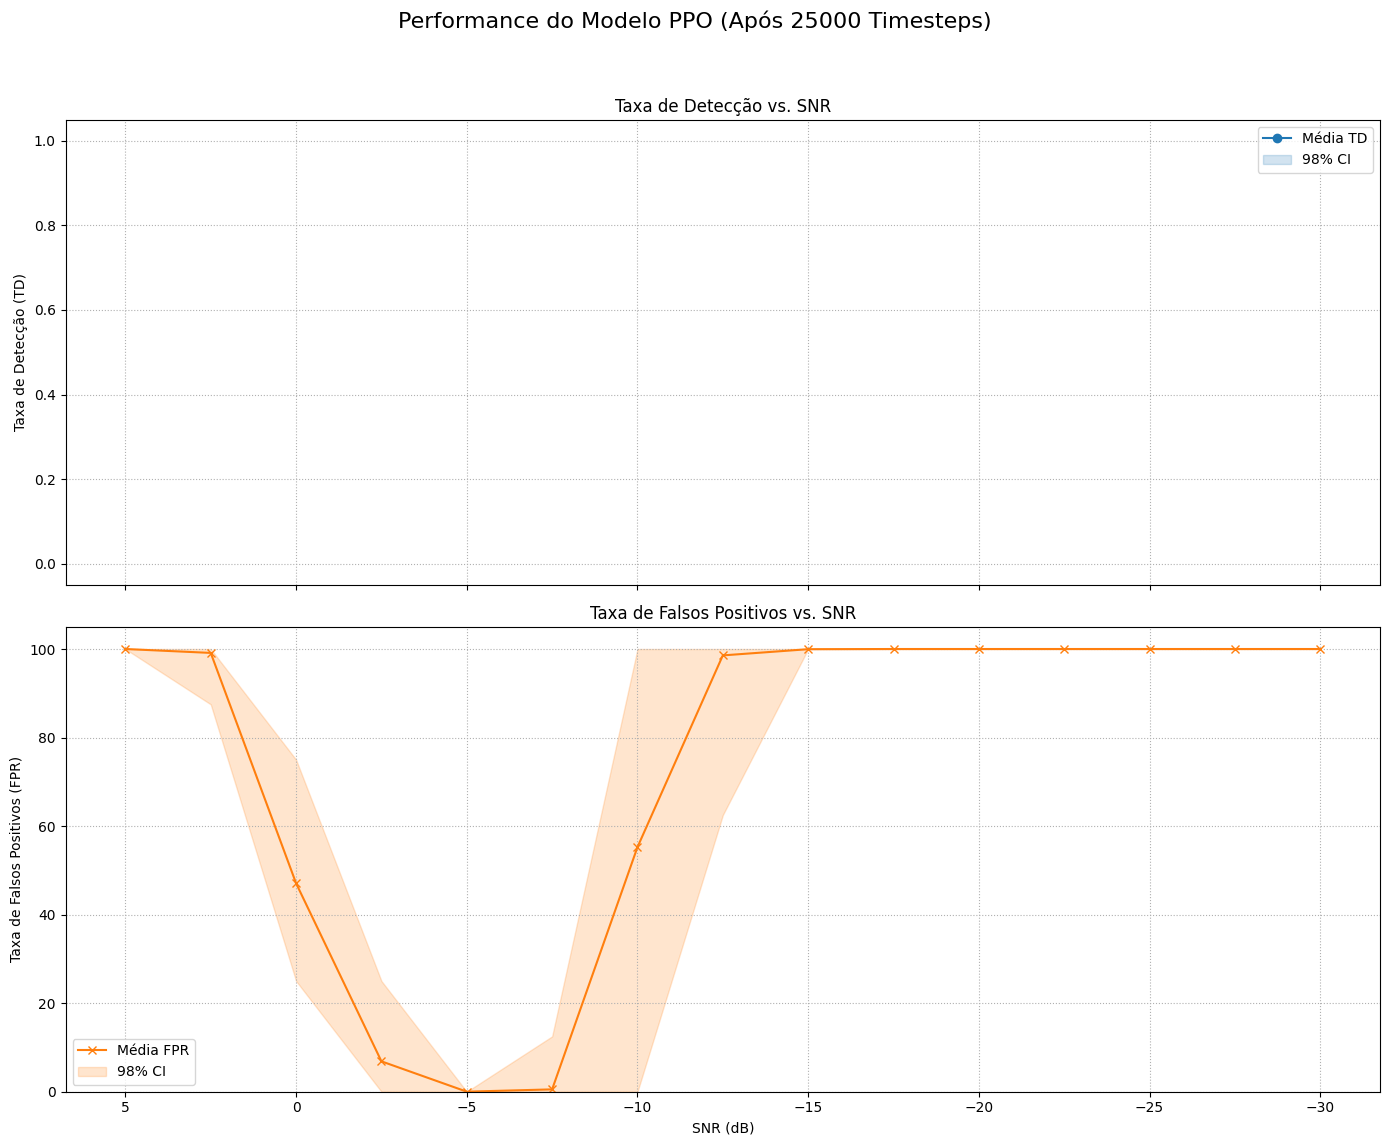

In [18]:
# -*- coding: utf-8 -*-
"""
Notebook Refatorado v18 para Treinamento de Modelo PPO com Múltiplos SNRs e Lógica de Ambiente Corrigida.

Esta versão corrige um IndexError no ambiente de simulação que ocorria ao usar
dados de múltiplos SNRs. A lógica do ambiente foi refatorada para interpretar
corretamente a estrutura de dados (trials, steps, features), garantindo que
a engenharia de features receba os dados no formato 2D esperado.
"""

# %% [markdown]
# # Treinamento de PPO com Múltiplos SNRs e Visualização Integrada (v18)
#
# # Este notebook treina um modelo PPO em múltiplos níveis de SNR e o avalia, gerando gráficos de performance detalhados para monitorar o aprendizado.

# %% [code]
# Importações essenciais
import pickle
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import BaseCallback
import torch as th
import matplotlib.pyplot as plt
import pandas as pd
import h5py
from tqdm import tqdm
import warnings

# Ignorar alguns avisos comuns para manter a saída limpa
warnings.filterwarnings("ignore", category=UserWarning)

# %% [markdown]
# ## Parâmetros de Controle e Configuração de Features

# %% [code]
# #####################################################################
# FEATURE ENGINEERING CONFIGURATION (AJUSTÁVEL PELO USUÁRIO)
# #####################################################################
FEATURE_NAMES = ['MSC', 'CSM', 'TFG', 'TFL', 'SNR_meas', 'MAG_freq', 'PHI_freq']
FEATURE_CONFIG = [
    # --- Features Simples (valor atual) ---
    ('MSC', 'simple', {}),
    ('CSM', 'simple', {}),
    ('TFL', 'simple', {}),
    ('SNR_meas', 'simple', {}),
    ('MAG_freq', 'simple', {}),

    # --- Features de Média Móvel ---
    ('MSC', 'moving_mean', {'window_size': 18}),
    ('CSM', 'moving_mean', {'window_size': 18}),
    ('TFL', 'moving_mean', {'window_size': 18}),
    ('MAG_freq', 'moving_mean', {'window_size': 18}),

    ('MSC', 'cumsum',{}),
    ('CSM', 'cumsum',{}),
    ('TFL', 'cumsum',{}),
    ('MAG_freq', 'cumsum',{}),

    # --- Feature de Tempo ---
    ('timestamp', 'simple', {})
]

# #####################################################################
# MODO DE EXECUÇÃO E PARÂMETROS GLOBAIS
# #####################################################################
DRY_RUN = False

if DRY_RUN:
    print("--- EXECUTANDO EM MODO DRY RUN (TESTE RÁPIDO) ---")
    TOTAL_TIMESTEPS_TREINO, EVAL_SIM_TIMESTEPS = 2500, 1000
    VERBOSE_LEVEL, VERBOSE_FREQ, SB3_LOG_FREQ = 1, 5, 10
else:
    print("--- EXECUTANDO EM MODO COMPLETO ---")
    TOTAL_TIMESTEPS_TREINO, EVAL_SIM_TIMESTEPS = 25000, 5000 # Ajustado para um treino mais longo
    VERBOSE_LEVEL, VERBOSE_FREQ, SB3_LOG_FREQ = 1, 25, 50

# #####################################################################
# CAMINHOS E CONSTANTES
# #####################################################################
HDF5_SIMULATED_FILEPATH = '../data/train.hdf5'
EXPERIMENTAL_FEATURES_FILE = '../data/experimental_features.hdf5'
NUM_SIGNAL_FREQS = 8

# %% [markdown]
# ## Funções de Plotagem e Auxiliares

# %% [code]
def plot_evaluation_results(results_df, training_step):
    """Plota as curvas de TD e FPR vs. SNR com intervalos de confiança de 98%."""
    if results_df.empty:
        print("Nenhum dado de avaliação para plotar.")
        return

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12), sharex=True)
    fig.suptitle(f'Performance do Modelo PPO (Após {training_step} Timesteps)', fontsize=16)

    td_data = results_df[results_df['Métrica'] == 'TD'].sort_values('SNR')
    ax1.plot(td_data['SNR'], td_data['Média'], label='Média TD', color='C0', marker='o')
    ax1.fill_between(td_data['SNR'], td_data['P1'], td_data['P99'], color='C0', alpha=0.2, label='98% CI')
    ax1.set_ylabel('Taxa de Detecção (TD)'); ax1.set_title('Taxa de Detecção vs. SNR')
    ax1.grid(True, linestyle=':'); ax1.legend(); ax1.set_ylim(-0.05, 1.05)

    fpr_data = results_df[results_df['Métrica'] == 'FPR'].sort_values('SNR')
    ax2.plot(fpr_data['SNR'], fpr_data['Média'], label='Média FPR', color='C1', marker='x')
    ax2.fill_between(fpr_data['SNR'], fpr_data['P1'], fpr_data['P99'], color='C1', alpha=0.2, label='98% CI')
    ax2.set_xlabel('SNR (dB)'); ax2.set_ylabel('Taxa de Falsos Positivos (FPR)')
    ax2.set_title('Taxa de Falsos Positivos vs. SNR')
    ax2.grid(True, linestyle=':'); ax2.legend(); ax2.set_ylim(bottom=-0.01)
    
    ax1.invert_xaxis()
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def calculate_statistics(metric_list):
    """Calcula estatísticas de uma lista de métricas (TPR ou FPR)."""
    metric_array = np.array(metric_list)
    return {
        'Média': np.mean(metric_array),
        'Variância': np.var(metric_array),
        'P1': np.percentile(metric_array, 1),
        'P99': np.percentile(metric_array, 99)
    }

# %% [markdown]
# ## Carga de Dados e Definição dos Ambientes

# %% [code]
def load_and_adapt_hdf5_data(sim_path, exp_path):
    c_states_simulado, c_states_experimental = {}, {}
    print(f"Carregando dados simulados de: {sim_path}")
    try:
        with h5py.File(sim_path, 'r') as f:
            snr_keys = sorted([k for k in f.keys() if 'snr' in k], key=lambda x: float(x.split('_')[1]))
            for key in snr_keys:
                snr_val = float(key.split('_')[1])
                c_states_simulado[snr_val] = f[key]['metrics'][:]
    except FileNotFoundError:
        print(f"AVISO: Arquivo de dados simulados '{sim_path}' não encontrado.")
    # ... (código para carregar dados experimentais omitido por brevidade) ...
    return c_states_simulado, c_states_experimental

def clean_data_dict(data_dict):
    for key, array in data_dict.items():
        if np.isnan(array).any() or np.isinf(array).any():
            data_dict[key] = np.nan_to_num(array, nan=0.0, posinf=0.0, neginf=0.0)
    return data_dict

def my_norm(val, min_val=0, max_val=3):
    return (val - min_val) / (max_val - min_val) if max_val != min_val else 0.0

class CustomLoggingCallback(BaseCallback):
    def __init__(self, log_freq: int, verbose=0):
        super().__init__(verbose)
        self.log_freq, self.episode_count = log_freq, 0
    def _on_step(self) -> bool:
        if any(self.locals["dones"]):
            self.episode_count += 1
            if self.episode_count % self.log_freq == 0 and self.logger.name_to_value:
                print(f"--- Logs (Episódio {self.episode_count}): ", end="")
                log_items = [f"{k}: {v:.4f}" for k, v in self.logger.name_to_value.items()]
                print(" | ".join(log_items))
        return True

class FeatureEngineEnv(gym.Env):
    def __init__(self, data, feature_config, feature_names):
        super().__init__()
        self.data, self.feature_config, self.feature_names = data, feature_config, feature_names
        self.feature_indices = {name: i for i, name in enumerate(feature_names)}
        num_output_features = sum(1 for _, _, _ in self.feature_config)
        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(num_output_features,), dtype=np.float32)

    def _generate_state(self, history_data, current_step, total_steps):
        state_features = []
        for feature, transform, params in self.feature_config:
            if feature == 'timestamp':
                state_features.append(current_step / total_steps if total_steps > 0 else 0)
                continue
            feature_idx = self.feature_indices[feature]
            feature_history = history_data[:current_step + 1, feature_idx]
            if transform == 'simple': val = feature_history[-1]
            elif transform == 'moving_mean':
                window = params.get('window_size', 10)
                val = np.mean(feature_history[max(0, len(feature_history) - window):])
            elif transform == 'cumsum': val = np.sum(feature_history)
            elif transform == 'cummean': val = np.mean(feature_history)
            else: raise ValueError(f"Transformação desconhecida: {transform}")
            state_features.append(my_norm(val))
        return np.array(state_features, dtype=np.float32)

# #####################################################################
# CLASSE DE AMBIENTE CORRIGIDA
# #####################################################################
class SimTrainingEnv(FeatureEngineEnv):
    def __init__(self, data, feature_config, feature_names, verbose_level=0, verbose_freq=10):
        # Data shape is (trials, steps, features)
        self.num_trials, self.num_steps, self.num_features = data.shape
        self.episodes = self.num_trials - 1
        self.frequencies = self.num_steps - 1
        super().__init__(data, feature_config, feature_names)
        self.verbose_level, self.verbose_freq = verbose_level, verbose_freq
        self.episode_count = -1
        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.episode_count += 1
        self.current_episode_idx = self.episode_count % (self.episodes + 1)
        # An episode corresponds to one full trial from the data.
        self.current_episode_data = self.data[self.current_episode_idx, :, :] # Shape: (steps, features)
        self.current_frequency = 0
        self.true_positives = 0
        self.false_positives = 0
        return self._get_state(), {}

    def step(self, action):
        should_detect = self.current_frequency < NUM_SIGNAL_FREQS
        tp,fp,fn,tn = (1,0,0,0) if action==1 and should_detect else (0,1,0,0) if action==1 and not should_detect else (0,0,1,0) if action==0 and should_detect else (0,0,0,1)
        if tp: self.true_positives += 1
        if fp: self.false_positives += 1
        reward = tp - 1.5*fp - fn + tn
        
        self.current_frequency += 1
        terminated = self.current_frequency > self.frequencies
        info = {}
        if terminated:
            num_noise_freqs = self.frequencies + 1 - NUM_SIGNAL_FREQS
            tp_rate = 100 * self.true_positives / NUM_SIGNAL_FREQS if NUM_SIGNAL_FREQS > 0 else 0
            fp_rate = 100 * self.false_positives / num_noise_freqs if num_noise_freqs > 0 else 0
            reward = ((tp_rate/100)**2) - ((fp_rate/100)**2)
            info = {'tp_rate': round(tp_rate,2), 'fp_rate': round(fp_rate,2)}
            if self.verbose_level > 0 and (self.episode_count+1) % self.verbose_freq == 0:
                print(f"--- Resumo (Episódio {self.episode_count+1}): TPR {info.get('tp_rate',0):.2f}%, FPR {info.get('fp_rate',0):.2f}%, Recompensa Final: {reward:.2f}")

        return self._get_state(), reward, terminated, False, info

    def _get_state(self):
        # Passa o histórico 2D do episódio atual para a engine de features
        # O estado é gerado apenas para o step (frequência) atual
        return self._generate_state(self.current_episode_data, self.current_frequency, self.frequencies)


c_states_simulado, _ = load_and_adapt_hdf5_data(HDF5_SIMULATED_FILEPATH, EXPERIMENTAL_FEATURES_FILE)
print("\nValidando e limpando dados...")
c_states_simulado = clean_data_dict(c_states_simulado)
print("Validação completa.")

# %% [markdown]
# ## Loop Principal de Treinamento e Avaliação com Plotagem Integrada

# %% [code]
# Defina a lista de SNRs que serão usados para treinar o modelo.
snr_treino_lista = [-5.0, -2.5, 0.0, 2.5, 5.0]
print(f"\nSNRs selecionados para treino: {snr_treino_lista}")

lista_dados_treino = [c_states_simulado[snr] for snr in snr_treino_lista if snr in c_states_simulado]

if lista_dados_treino:
    dados_treino = np.vstack(lista_dados_treino)
    print(f"Dados de treino combinados de {len(lista_dados_treino)} níveis de SNR. Shape final: {dados_treino.shape}")

    # --- Treinamento ---
    print(f"\n{'='*80}\n--- TREINANDO MODELO PPO ---\n{'='*80}")
    env = DummyVecEnv([lambda: SimTrainingEnv(dados_treino, FEATURE_CONFIG, FEATURE_NAMES, VERBOSE_LEVEL, VERBOSE_FREQ)])
    policy_kwargs = dict(activation_fn=th.nn.ReLU, net_arch=dict(pi=[64, 64], vf=[64, 64]))
    model = PPO('MlpPolicy', env, verbose=0, policy_kwargs=policy_kwargs, n_steps=2048)
    model.learn(total_timesteps=TOTAL_TIMESTEPS_TREINO, callback=CustomLoggingCallback(log_freq=SB3_LOG_FREQ))
    model.save('modelo_ppo.zip')
    print("Modelo 'modelo_ppo.zip' salvo.\n")

    # --- Avaliação e Plotagem ---
    print(f"\n{'='*80}\n--- AVALIANDO MODELO EM DADOS SIMULADOS ---\n{'='*80}")
    all_results_data = []
    snr_list = sorted(c_states_simulado.keys())
    if DRY_RUN: snr_list = [snr for snr in snr_list if snr in [0.0, -5.0]]

    for snr in tqdm(snr_list, desc="Avaliando por SNR"):
        eval_data = c_states_simulado[snr]
        eval_env = SimTrainingEnv(eval_data, FEATURE_CONFIG, FEATURE_NAMES)
        
        tpr_list, fpr_list = [], []
        obs, _ = eval_env.reset()
        
        for _ in range(EVAL_SIM_TIMESTEPS):
            action, _ = model.predict(obs, deterministic=True)
            obs, _, terminated, _, info = eval_env.step(action)
            if terminated:
                if 'tp_rate' in info and not np.isnan(info['tp_rate']):
                    tpr_list.append(info['tp_rate'])
                    fpr_list.append(info['fp_rate'])
                obs, _ = eval_env.reset()

        if tpr_list:
            td_stats = calculate_statistics(tpr_list)
            fpr_stats = calculate_statistics(fpr_list)
            all_results_data.append({'SNR': snr, 'Métrica': 'TD', **td_stats})
            all_results_data.append({'SNR': snr, 'Métrica': 'FPR', **fpr_stats})

    results_df = pd.DataFrame(all_results_data)
    plot_evaluation_results(results_df, TOTAL_TIMESTEPS_TREINO)

else:
    print(f"ERRO: Nenhum dado de treino encontrado para os SNRs especificados. Experimento abortado.")